In [1]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle

In [2]:
import pickle
from IPython.core.display import display, HTML, Markdown

/tmp/ipykernel_15218/659417397.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [3]:
from mvpa2.datasets.mri import fmri_dataset

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [4]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.


Version 5 uses scikit-learn directly, bypassing mvpa2's framework altogether. We also implement a 'forced choice' scorer.

In [5]:
from visualization import visualize_corr
import mvpa2

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/visualization.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [6]:
import sys
import os

sys.path.append(os.path.abspath("../../ml/"))


## Load

In [7]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [8]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [9]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [10]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [11]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [12]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

## new code

In [13]:
from sklearn.model_selection import LeaveOneGroupOut

In [14]:
from sklearn.svm import LinearSVC
from scipy.stats import ttest_1samp, pearsonr

def pearson_img_series(img_series,img_cor):
    #iterate through the series
    img_length = img_series.shape[0]
    pearson_img_result = [0]*img_length
    
    for img_i in range(img_length):
        #now get the similarity
        #print(Brain_Data_allsubs[img_i,].samples.flatten().shape)
        #print(linearSVC_results['classifier'].coef_.flatten().shape)
        pearson_result = pearsonr(
            img_series[img_i,].flatten(),
            img_cor.flatten()
        )
        #we need the positive and the negative image to do this correctly
        #we're just going to assume that the positive should come first, that the classifier
        pearson_img_result[img_i] = [-pearson_result[0],pearson_result[0]]
        #print(pearson_result[0])
        
    return(pearson_img_result)

def do_LinearSVC(train_X,train_y,test_X,test_y):
    sklearn_clf = LinearSVC(penalty='l2', max_iter=1e4)
    #same as v3, my nilearn learner integrated with nltools
    #https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html
    
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    #we'll use similarity/correlation here.
    predict_y_prob = pearson_img_series(test_X,sklearn_clf.coef_)#sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


In [15]:
def do_SVC(train_X,train_y,test_X,test_y):
    sklearn_clf = SVC(probability=True)

    #create the classifier with a probability function
    #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
    #we don't need this I'm doing my own probability estimate
    #hmmm, is this why the model is performing so well? the tuning?
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    predict_y_prob = sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


def do_forced_choice(dataset,normalization=None,get_predict_and_prob=None):
    if get_predict_and_prob is None:
        get_predict_and_prob = do_SVC
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []
    
    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            #print("normalizing")
        
        predict_y, y_class_match, sklearn_clf = get_predict_and_prob(train_X,train_y,test_X,test_y)
        
        
        #need to label the output of the probability as CorrectStop and CorrectGo based on the classnames
        #iterate through each class
        proba_dict = {}
        for i, cls in enumerate(sklearn_clf.classes_):
            proba_dict[cls] = [x[i] for x in y_class_match]
            
        class_0 = sklearn_clf.classes_[0]
        class_1 = sklearn_clf.classes_[1]

        #find out which one of the two images is most likely to be CorrectGo
        class_0_choice_index = np.argmax(proba_dict[class_0])
        #now put that into a vector
        forced_choice_predictions = [class_1]*2
        forced_choice_predictions[class_0_choice_index] = class_0
        accuracy_score = np.sum([pred==target for pred,target in zip(forced_choice_predictions,test_y)])/len(test_y)
        #can we do a sample-wise table?

        group_scores[iteration_label] = accuracy_score
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
            'pred_y_forced_choice':forced_choice_predictions
        })
        #add the class-wise probabilities
        for cls in sklearn_clf.classes_:
            sample_wise_results_iter['pred_prob_' + cls] = proba_dict[cls]
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    #we test and train on the same here, which is OK, because we don't use this to assess performance
    y_predict, y_class_match, clf_svc_final =get_predict_and_prob(
        dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,'group_wise':group_scores,'classifier':clf_svc_final})


In [16]:
def setup_metadata(bd,target_attri_label = 'condition_label', standardize=False):
    #set up chunks and targets so we can do the learning.
    attribute_df = sa_to_df(bd.sa)
    pd.concat([attribute_df['subject'],attribute_df['wave']],axis=1)
    chunk = attribute_df['subject']+"_" + attribute_df['wave'].astype(str)
    bd.sa['chunks'] = list(chunk)
    if standardize:
        target_data = bd.sa[target_attri_label].value
        target_data_mean = np.nanmean(target_data)
        target_data_std = np.nanstd(target_data)
        target_data_norm = (target_data-target_data_mean)/target_data_std
        bd.sa['targets'] = list(target_data_norm)
    else:
        bd.sa['targets'] = list(bd.sa[target_attri_label].value)

    return(bd)

In [17]:
def remove_selected_outliers_mvpa_tesq_study(
    ind_div_combined,
    show_plot=False,
    neural_measures = ['CorGo_ln_inv_pred_prob_CorrectGo','CorStop_ln_inv_pred_prob_CorrectStop']):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','TESQ_E_sum','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy','cancer_promoting_minus_preventing_FFQ','bf_1'] + neural_measures,
    show_plot=show_plot)
    return(idc_outliers_removed)

In [18]:

import math
def inv_log_transform(series):
    series=series.copy()
    not_na_vals = np.isnan(series)==False
    log_vals = [math.log(1-x) for x in (series[not_na_vals])]
    series[not_na_vals] = log_vals
    return(log_vals)


In [19]:
from outlier_detection import *

def print_forced_choice_results(forced_choice_results, neural_measures = ['pred_prob_CorrectStop']):
    prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
    print((prediction, forced_choice_prediction))
    
    sample_wise_results = forced_choice_results['sample_wise']
    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')
    
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(full_dataset_cs,neural_measures = neural_measures)
    
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        visualize_corr(nm,'bf_1',full_dataset_cs)
        visualize_corr(nm,'cancer_promoting_minus_preventing_FFQ',full_dataset_cs)
        visualize_corr(nm,'TESQ_E_sum',full_dataset_cs)
    
    

    

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/outlier_detection.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


## whole brain

In [20]:
from sklearn.model_selection import LeaveOneGroupOut

In [21]:
from sklearn.svm import SVC
#from mvpa2.measures.base import CrossValidation
#from mvpa2.clfs.meta import NFoldPartitioner
#from mvpa2.clfs.svm import LinearCSVMC
from sklearn.calibration import CalibratedClassifierCV


Now let's scale that up to the full dataset.

In [22]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

In [23]:
results_filepath=ml_data_folderpath + "/SST/ttr_mvpa2_res_v5_conditions_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

relevant_mask = None

In [24]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [25]:
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [26]:
if os.path.exists(results_filepath):
    with open(results_filepath, 'rb') as pkl_file:
        forced_choice_results = pickle.load(pkl_file)
else:
    forced_choice_results = do_forced_choice(Brain_Data_allsubs)
    with open(results_filepath, 'wb') as pkl_file:
        pickle.dump(forced_choice_results,file=pkl_file)

    

In [27]:
forced_choice_results['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop
0,DEV005_1,CorrectGo,CorrectGo,CorrectGo,0.950488,0.049512
1,DEV005_1,CorrectStop,CorrectStop,CorrectStop,0.088201,0.911799
0,DEV006_1,CorrectGo,CorrectGo,CorrectGo,0.992946,0.007054
1,DEV006_1,CorrectStop,CorrectStop,CorrectStop,0.179542,0.820458
0,DEV010_1,CorrectGo,CorrectGo,CorrectGo,0.989892,0.010108
...,...,...,...,...,...,...
1,DEV216_1,CorrectStop,CorrectStop,CorrectStop,0.236497,0.763503
0,DEV217_1,CorrectGo,CorrectGo,CorrectGo,0.984806,0.015194
1,DEV217_1,CorrectStop,CorrectStop,CorrectStop,0.050841,0.949159
0,DEV218_1,CorrectGo,CorrectStop,CorrectGo,0.517527,0.482473


In [28]:
total_score = np.mean(list(forced_choice_results['group_wise'].values()))
total_score

0.9876543209876543

Alright--and how about if we don't do the forced-choice?

In [29]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [30]:
print(prediction)
print(forced_choice_prediction)

0.9506172839506173
0.9876543209876543


## masks

We get the same file this time, but we apply a mask before doing learning.

In [31]:
from generic_utils import *

In [32]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [33]:
for mask_name in all_masks['mask_name']:
#    mask_value = all_masks[mask_name]
    print(mask_name,end=", ")

planning_association-test_z_FDR_0.01, executive function_association-test_z_FDR_0.01, response inhibition_association-test_z_FDR_0.01, inhibition_association-test_z_FDR_0.01, harvardoxford-cortical_prob_Frontal Orbital Cortex, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis, 

### try out one mask

In [34]:
brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl"

#brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Insular Cortex.pkl"
#brain_data_filepath = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_response inhibition_association-test_z_FDR_0.01.pkl'

In [35]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


In [36]:
Brain_Data_allsubs[0].samples

array([[ 3.2524042 ,  3.12158   ,  3.463699  , ...,  1.1899438 ,
         0.46779376, -0.2717672 ]], dtype=float32)

In [37]:
from nilearn.masking import unmask

masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


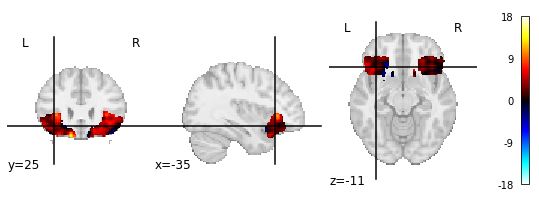

In [38]:
from nilearn import plotting

plotting.plot_stat_map(masked_preview,vmax=18)

In [39]:
from mvpa2.mappers.flatten import mask_mapper
import nibabel as nib

In [40]:
Brain_Data_allsubs.samples[np.isnan(Brain_Data_allsubs.samples)]=0

In [41]:
sum(sum(np.isnan(Brain_Data_allsubs[0,:].samples)))

0

In [42]:
Brain_Data_allsubs[0,:].samples

array([[ 3.2524042 ,  3.12158   ,  3.463699  , ...,  1.1899438 ,
         0.46779376, -0.2717672 ]], dtype=float32)

In [64]:
forced_choice_results = do_forced_choice(Brain_Data_allsubs)

.................................................................................

In [65]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
print(prediction,forced_choice_prediction)

0.9506172839506173 0.9753086419753086


yikes, that does seem a bit too good. Particularly considering that the non-forced-choice rsults are also up really high. We shouldn't be seeing resutls this high! Let's see how it goes across all the masks I have chosen.

planning_association-test_z_FDR_0.01
2705.6913580246915
.................................................................................
0.9320987654320988 0.9876543209876543
executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9135802469135802 0.9753086419753086
response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9382716049382716 0.9753086419753086
inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9259259259259259 0.9753086419753086
harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9506172839506173 0.9753086419753086
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9320987654320988 0.9753086419753086
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9444444444444444 0.9753086419753086


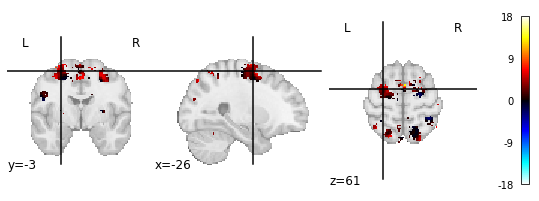

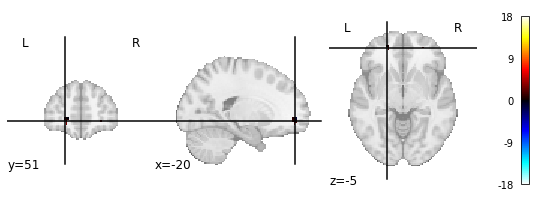

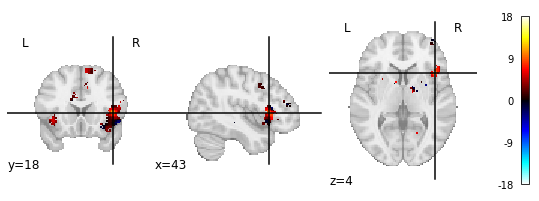

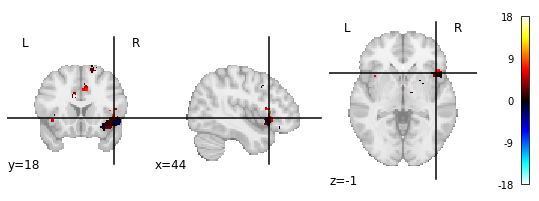

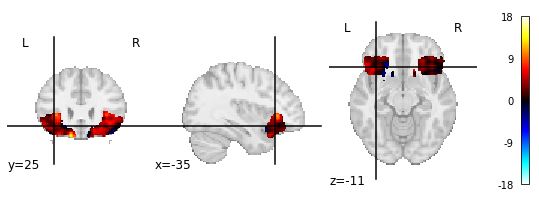

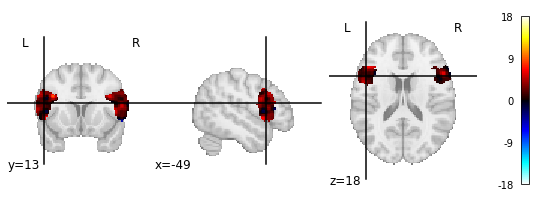

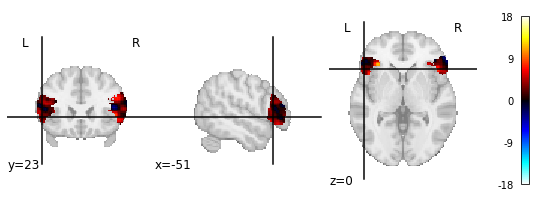

In [32]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

Next to do:
1. Consider re-implementing LinearSVM and getting similarity rather than this probability measure
2. Visualize for all the other values.

Now we've decoupled the learner from the framework where we apply it, we can pass in any arbitrary learner. It just has to output:

1. predictions 
2. prediction confidence 
3. the classifier itself

## Re-implementing v3: Correlation similarity with LinearSVC

This is a useful sanity check, becuase it's helpufl to try and explain why we're doing so much  better than rpeviously.

In [35]:

def do_LinearSVC(train_X,train_y,test_X,test_y):
    sklearn_clf = LinearSVC(penalty='l2', max_iter=1e4)
    #same as v3, my nilearn learner integrated with nltools
    #https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html
    
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    #we'll use similarity/correlation here.
    predict_y_prob = pearson_img_series(test_X,sklearn_clf.coef_)#sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


In [36]:
linear_results_with_similarity = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)

.................................................................................

In [38]:
forced_choice_results = linear_results_with_similarity

In [39]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [40]:
(prediction, forced_choice_prediction)

(0.691358024691358, 0.9012345679012346)

Formerly this was .85, .95, which was remarkable--we've now pretty clearly reproduced the result we were getting using nltools..

However, after I updated it based on documentation here (https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html) it performed less well. Not sure why the classifier is performing _less_ well in this setup than the former one - perhaps hte sort of normalization that I am doing on each side.

In [41]:
sample_wise_results = forced_choice_results['sample_wise']
cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')


In [42]:
from outlier_detection import *



/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/outlier_detection.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [63]:
full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(
    full_dataset_cs,
    neural_measures = ['pred_prob_CorrectStop'])

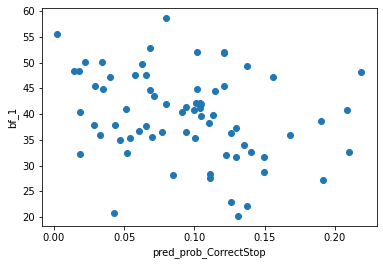

In [238]:
visualize_corr('pred_prob_CorrectStop','bf_1',full_dataset_cs)

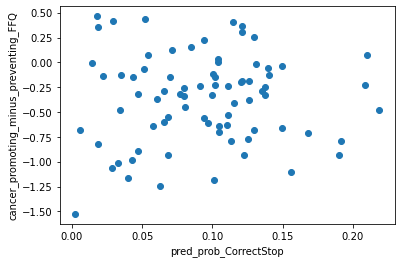

In [242]:
visualize_corr('pred_prob_CorrectStop','cancer_promoting_minus_preventing_FFQ',full_dataset_cs)

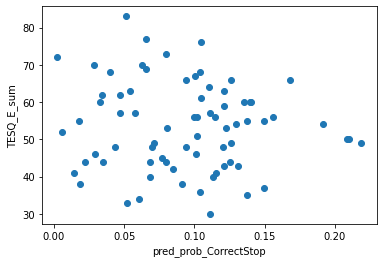

In [240]:
visualize_corr('pred_prob_CorrectStop','TESQ_E_sum',full_dataset_cs)

#### v3 mask

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7407407407407407 0.9629629629629629
executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7037037037037037 0.8641975308641975
response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6851851851851852 0.9753086419753086
inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6172839506172839 0.8765432098765432
harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6666666666666666 0.9135802469135802
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.7098765432098766 0.9382716049382716
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.691358024691358 0.9012345679012346


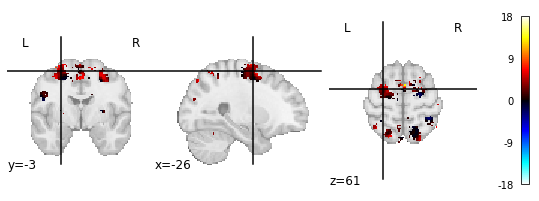

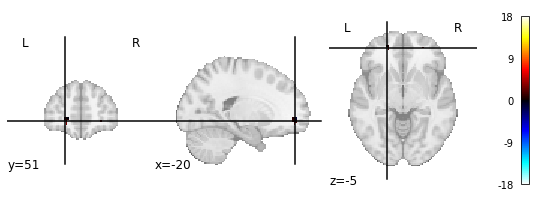

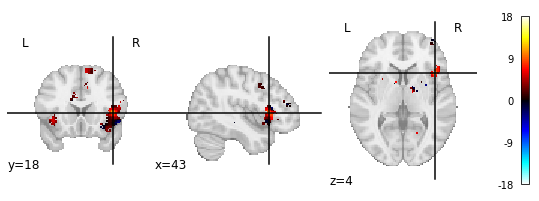

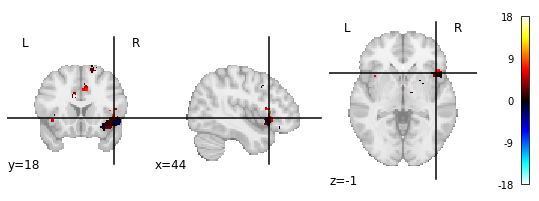

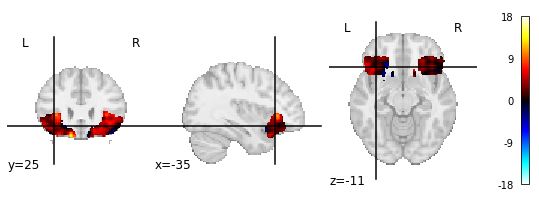

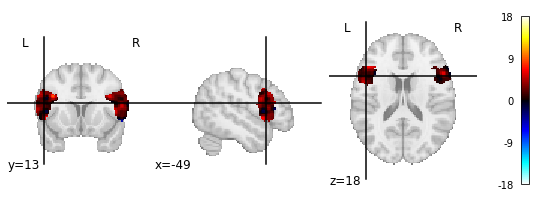

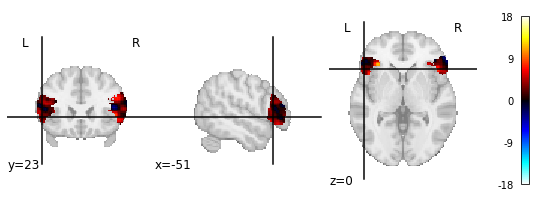

In [67]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

planning_association-test_z_FDR_0.01
(0.7407407407407407, 0.9629629629629629)


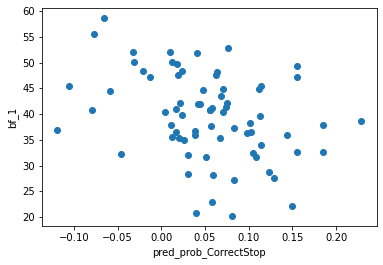

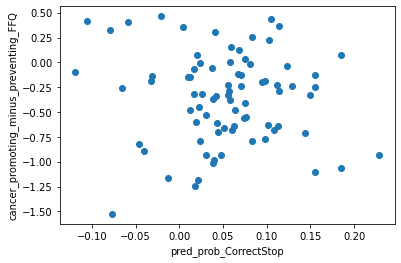

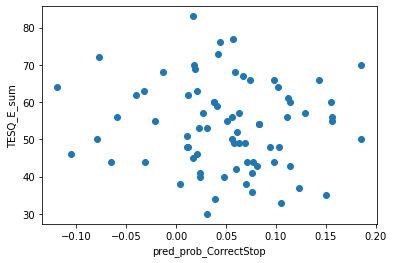

executive function_association-test_z_FDR_0.01
(0.7037037037037037, 0.8641975308641975)


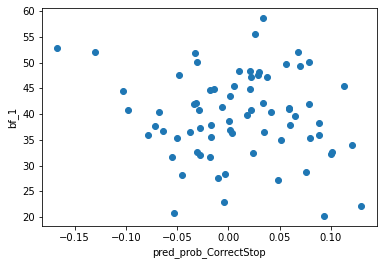

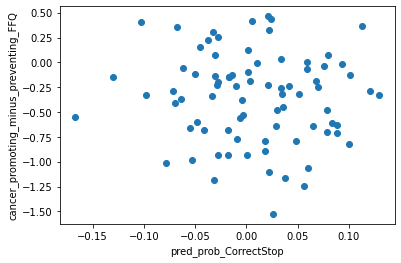

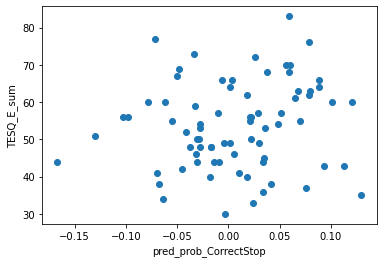

response inhibition_association-test_z_FDR_0.01
(0.6851851851851852, 0.9753086419753086)


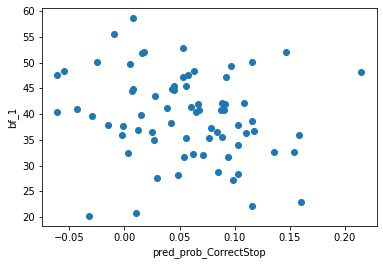

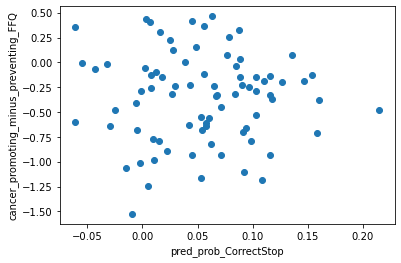

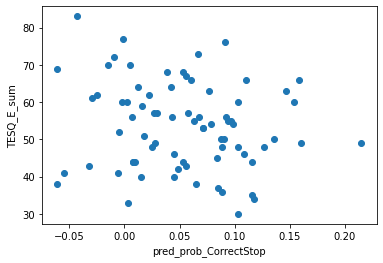

inhibition_association-test_z_FDR_0.01
(0.6172839506172839, 0.8765432098765432)


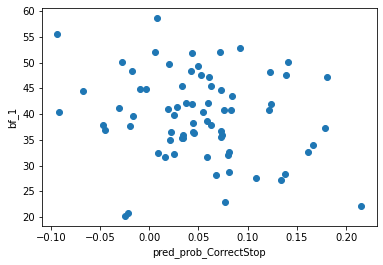

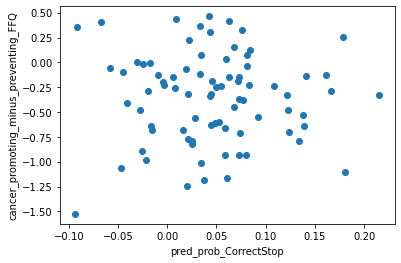

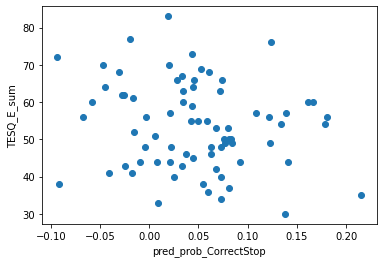

harvardoxford-cortical_prob_Frontal Orbital Cortex
(0.6666666666666666, 0.9135802469135802)


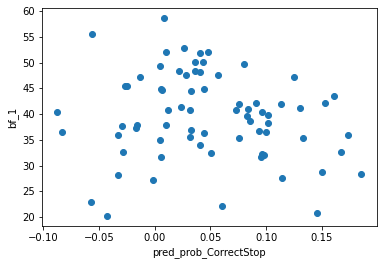

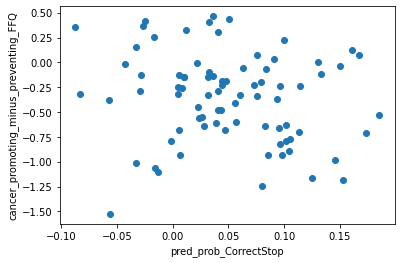

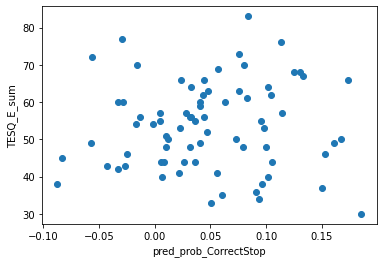

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
(0.7098765432098766, 0.9382716049382716)


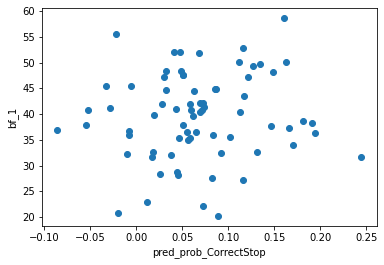

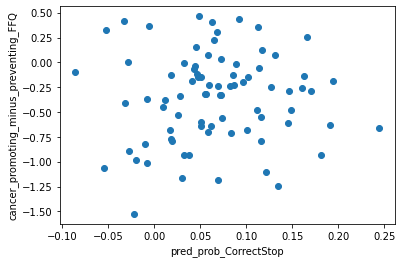

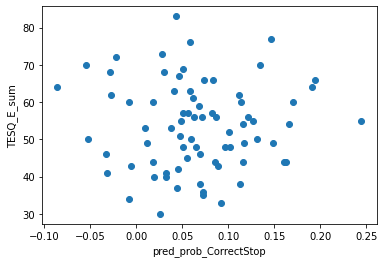

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
(0.691358024691358, 0.9012345679012346)


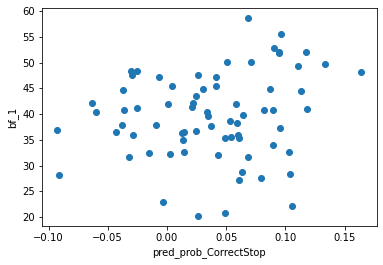

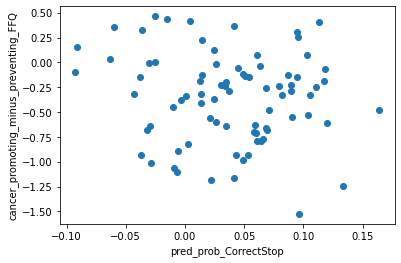

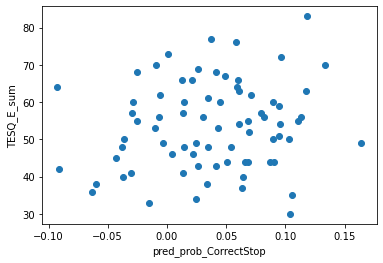

In [68]:
for k in forced_choice_results_dict.keys():
    v=forced_choice_results_dict[k]
    print(k)
    print_forced_choice_results(v,['pred_prob_CorrectStop'])

## Predictive probability with SVC

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9320987654320988 0.9876543209876543
(0.9320987654320988, 0.9876543209876543)


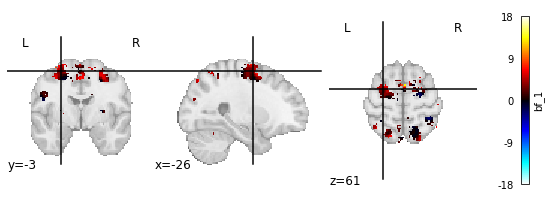

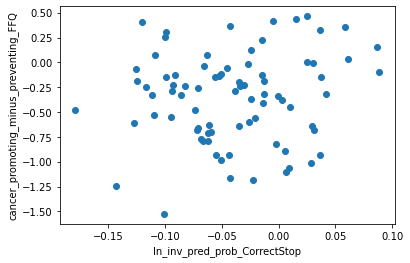

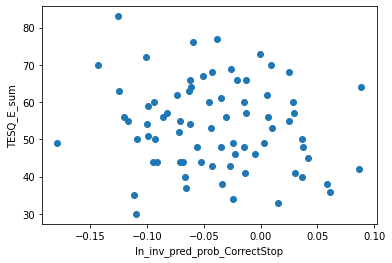

executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9135802469135802 0.9753086419753086
(0.9135802469135802, 0.9753086419753086)


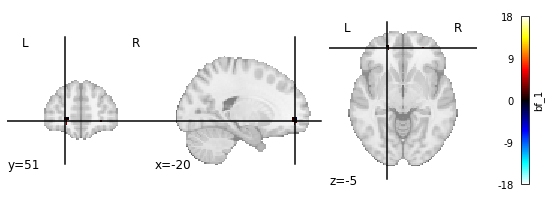

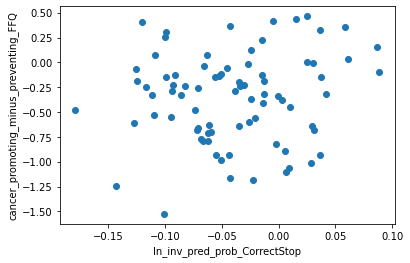

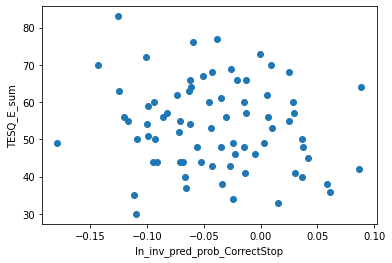

response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9382716049382716 0.9753086419753086
(0.9382716049382716, 0.9753086419753086)


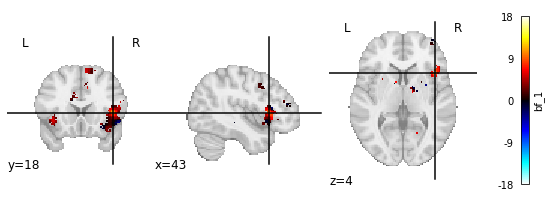

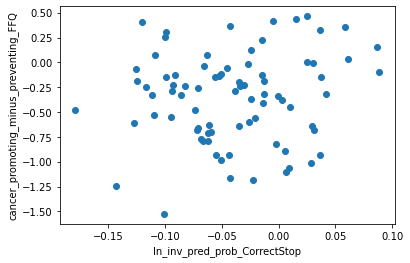

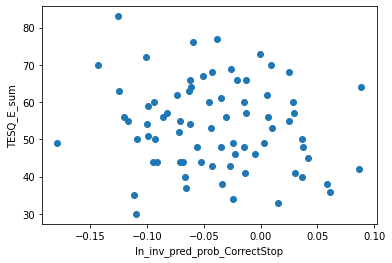

inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9259259259259259 0.9753086419753086
(0.9259259259259259, 0.9753086419753086)


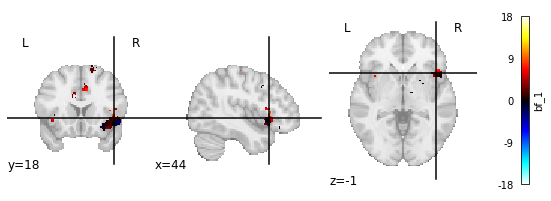

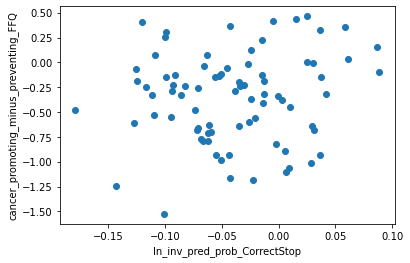

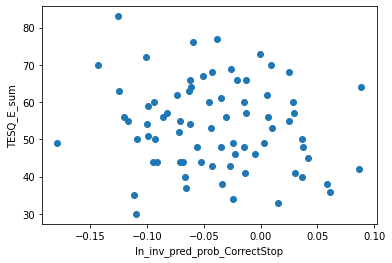

harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9506172839506173 0.9753086419753086
(0.9506172839506173, 0.9753086419753086)


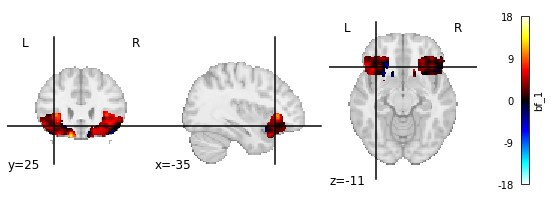

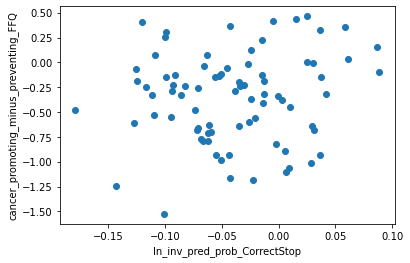

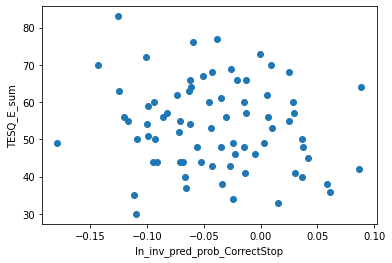

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9320987654320988 0.9753086419753086
(0.9320987654320988, 0.9753086419753086)


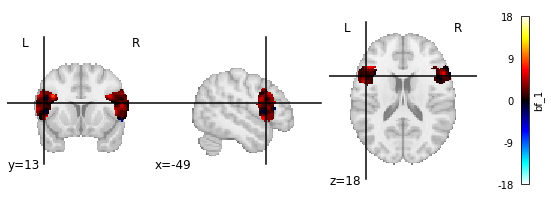

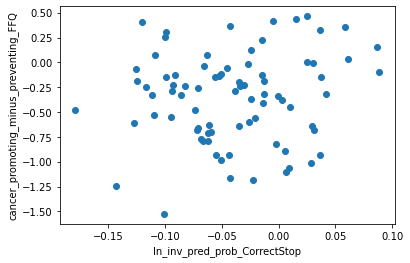

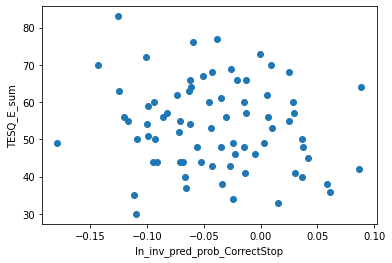

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9444444444444444 0.9753086419753086
(0.9444444444444444, 0.9753086419753086)


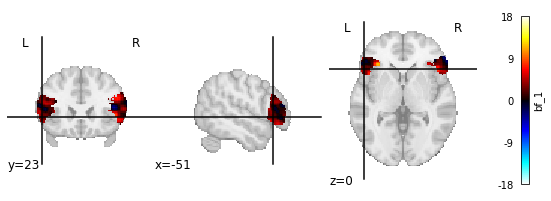

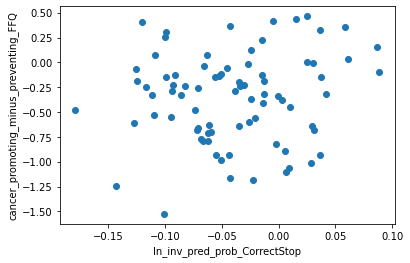

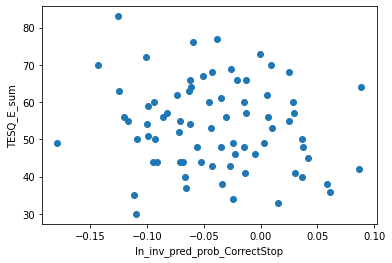

In [74]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])


        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(forced_choice_results,['ln_inv_pred_prob_CorrectStop'])

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


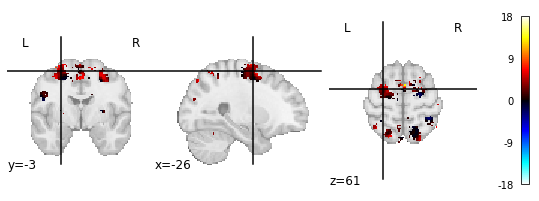

.................................................................................
0.9320987654320988 0.9876543209876543
(0.9320987654320988, 0.9876543209876543)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                        0.035997
4                       -0.026463
..                            ...
196                     -0.071497
197                           NaN
198                           NaN
199                           NaN
200                      0.004667

[201 rows x 1 columns]


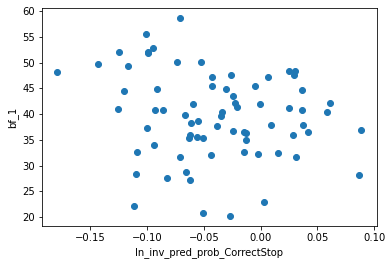

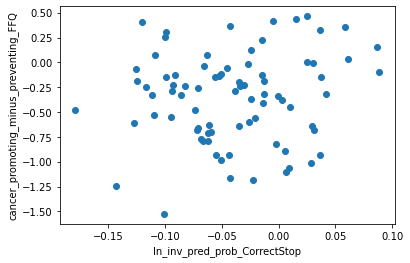

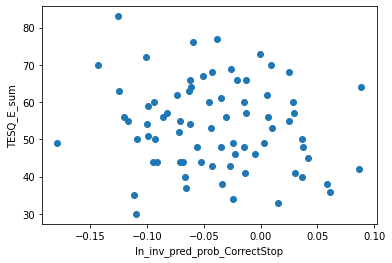

executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


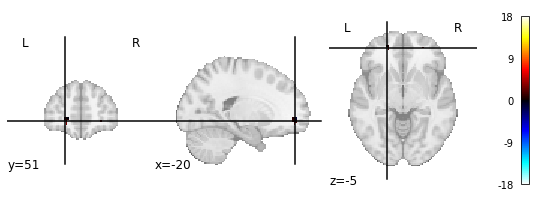

.................................................................................
0.9135802469135802 0.9753086419753086
(0.9135802469135802, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                        0.035997
4                       -0.026463
..                            ...
196                     -0.071497
197                           NaN
198                           NaN
199                           NaN
200                      0.004667

[201 rows x 1 columns]


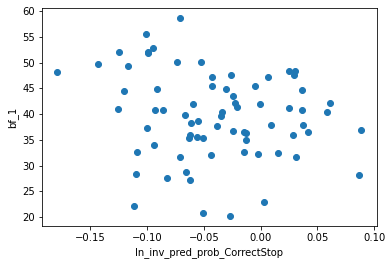

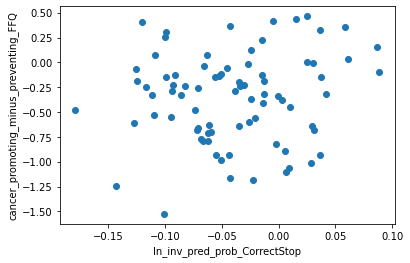

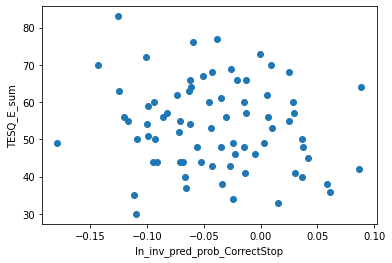

response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


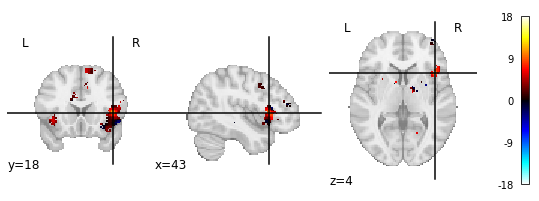

.................................................................................
0.9382716049382716 0.9753086419753086
(0.9382716049382716, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                        0.035997
4                       -0.026463
..                            ...
196                     -0.071497
197                           NaN
198                           NaN
199                           NaN
200                      0.004667

[201 rows x 1 columns]


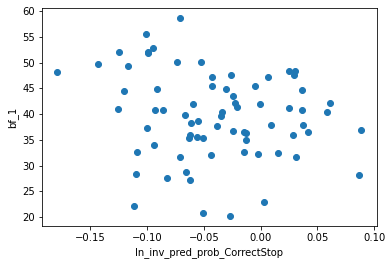

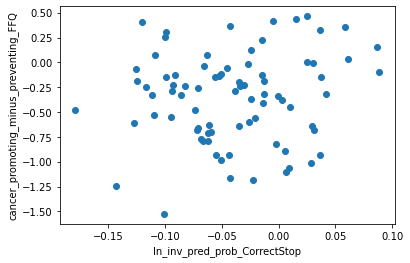

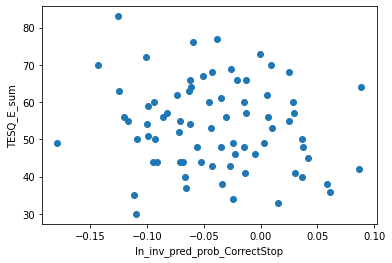

inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


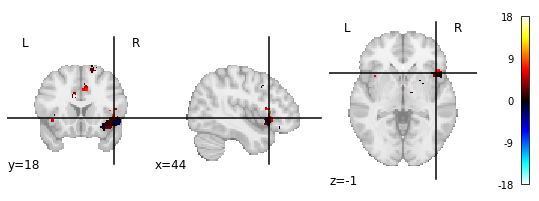

.................................................................................
0.9259259259259259 0.9753086419753086
(0.9259259259259259, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                        0.035997
4                       -0.026463
..                            ...
196                     -0.071497
197                           NaN
198                           NaN
199                           NaN
200                      0.004667

[201 rows x 1 columns]


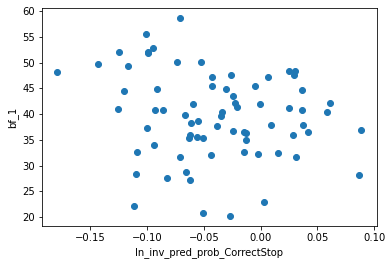

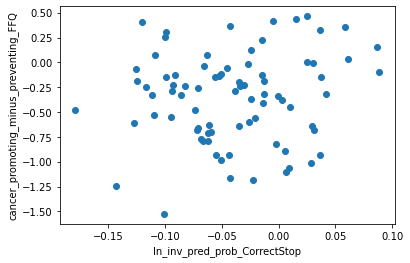

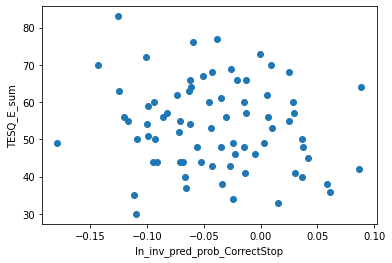

harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


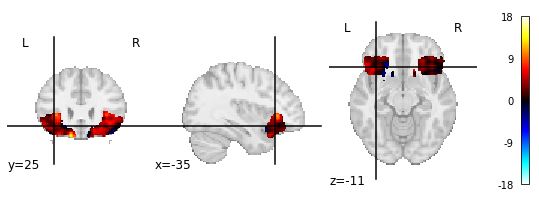

.................................................................................
0.9506172839506173 0.9753086419753086
(0.9506172839506173, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                        0.035997
4                       -0.026463
..                            ...
196                     -0.071497
197                           NaN
198                           NaN
199                           NaN
200                      0.004667

[201 rows x 1 columns]


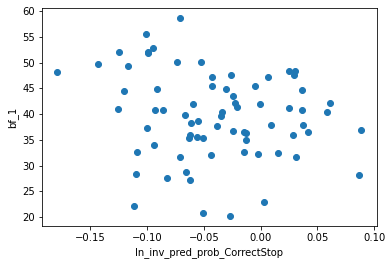

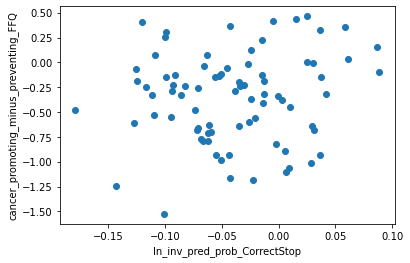

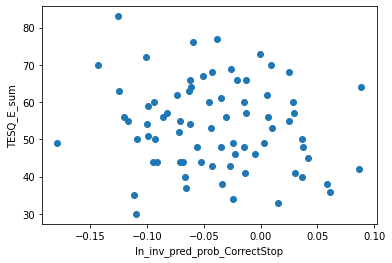

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


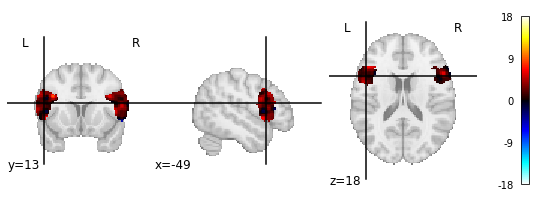

.................................................................................
0.9320987654320988 0.9753086419753086
(0.9320987654320988, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                        0.035997
4                       -0.026463
..                            ...
196                     -0.071497
197                           NaN
198                           NaN
199                           NaN
200                      0.004667

[201 rows x 1 columns]


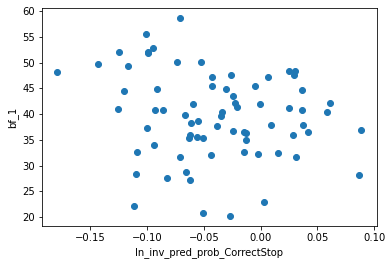

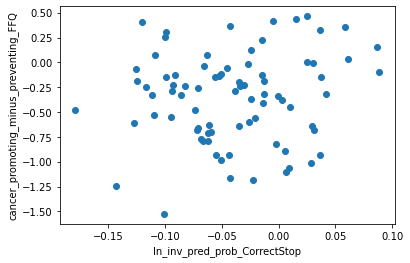

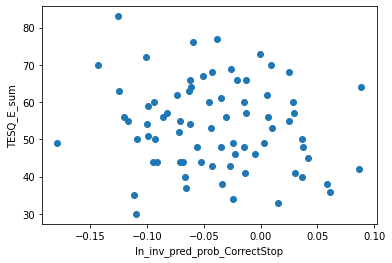

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


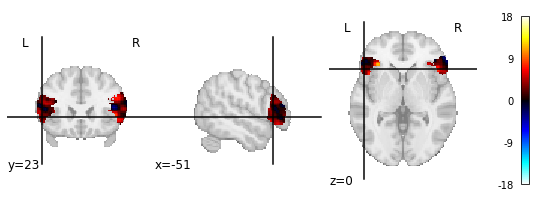

.................................................................................
0.9444444444444444 0.9753086419753086
(0.9444444444444444, 0.9753086419753086)
     ln_inv_pred_prob_CorrectStop
0                             NaN
1                             NaN
2                             NaN
3                        0.035997
4                       -0.026463
..                            ...
196                     -0.071497
197                           NaN
198                           NaN
199                           NaN
200                      0.004667

[201 rows x 1 columns]


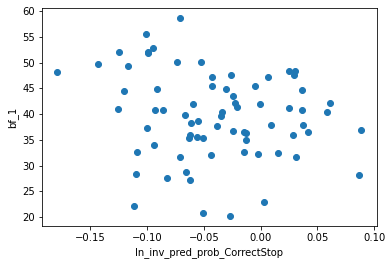

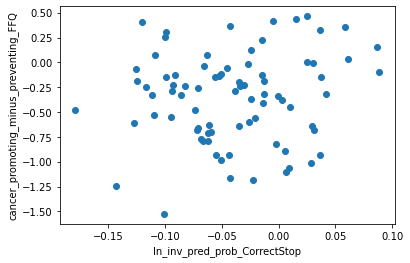

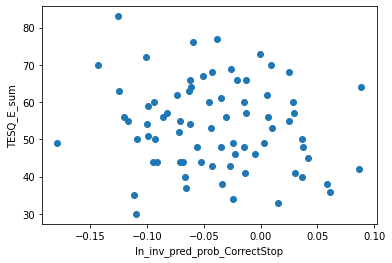

In [78]:
from outlier_detection import *

def print_forced_choice_results(fcr, neural_measures = ['pred_prob_CorrectStop']):
    prediction = np.mean(fcr['sample_wise']['target_y']==fcr['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(fcr['sample_wise']['target_y']==fcr['sample_wise']['pred_y_forced_choice'])
    print((prediction, forced_choice_prediction))
    
    sample_wise_results = fcr['sample_wise']
    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')
    
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(full_dataset_cs,neural_measures = neural_measures)
    
    print(full_dataset_cs[neural_measures])
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        visualize_corr(nm,'bf_1',full_dataset_cs)
        visualize_corr(nm,'cancer_promoting_minus_preventing_FFQ',full_dataset_cs)
        visualize_corr(nm,'TESQ_E_sum',full_dataset_cs)
    
    

    

forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])


        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(forced_choice_results,['ln_inv_pred_prob_CorrectStop'])

whole brain
127427.37037037036
.................................................................................0.9506172839506173 0.9876543209876543
(0.9506172839506173, 0.9876543209876543)


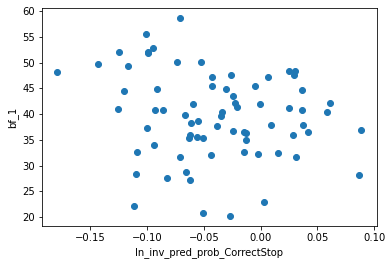

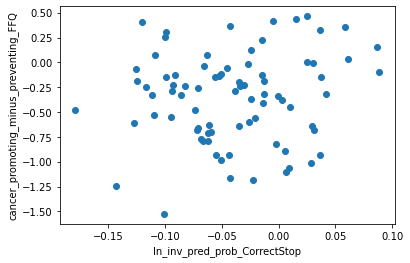

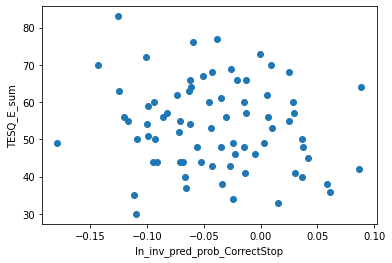

In [76]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
print_forced_choice_results(forced_choice_results,['ln_inv_pred_prob_CorrectStop'])

## Contrast between CorrectStop and CorrectGo...

In [39]:
from sklearn.linear_model import Ridge

def do_Ridge(train_X,train_y,test_X,test_y):
    sklearn_reg = Ridge()

    #create the classifier with a probability function
    #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
    #we don't need this I'm doing my own probability estimate
    #hmmm, is this why the model is performing so well? the tuning?
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_reg.fit(train_X, train_y)

    #get the _distance_ between predicted and actual
    #predict_y_prob = sklearn_reg.predict_proba(test_X)
    predict_y = sklearn_reg.predict(test_X)
    return(predict_y,sklearn_reg)


def do_regression(dataset,normalization=None,get_predict_and_prob=None):
    if get_predict_and_prob is None:
        get_predict_and_prob = do_Ridge
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []
    
    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            #print("normalizing")
        
        predict_y, sklearn_reg = get_predict_and_prob(train_X,train_y,test_X,test_y)
        
        
        mae = abs(predict_y - test_y)

        accuracy_score = np.sum(mae)/len(mae)
        #can we do a sample-wise table?

        group_scores[iteration_label] = accuracy_score
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
            'mae' : accuracy_score
            #'pred_y_forced_choice':forced_choice_predictions
        })
#         #add the class-wise probabilities
#         for cls in sklearn_clf.classes_:
#             sample_wise_results_iter['pred_prob_' + cls] = proba_dict[cls]
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    #we test and train on the same here, which is OK, because we don't use this to assess performance
    y_predict, model_final =get_predict_and_prob(
        dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,'group_wise':group_scores,'model':model_final})


In [58]:
def print_regression_results(forced_choice_results, neural_measures = ['mae']):
    sample_wise_results = forced_choice_results['sample_wise']
#    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(sample_wise_results,how='outer',left_on='subj_wave',right_on='chunks')
    print(full_dataset_cs.columns)
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(
        full_dataset_cs,neural_measures = neural_measures,
        show_plot=False)
    
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        visualize_corr(nm,'bf_1',full_dataset_cs)
        visualize_corr(nm,'cancer_promoting_minus_preventing_FFQ',full_dataset_cs)
        visualize_corr(nm,'TESQ_E_sum',full_dataset_cs)
    
    

    

In [41]:
#", ".join(sa_to_df(Brain_Data_allsubs.sa).columns)

planning_association-test_z_FDR_0.01
1685.1518987341772


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


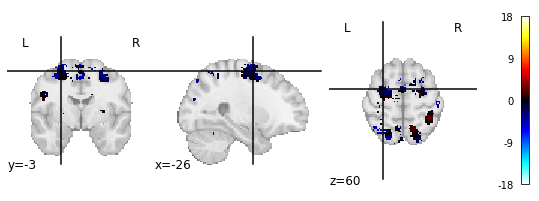

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


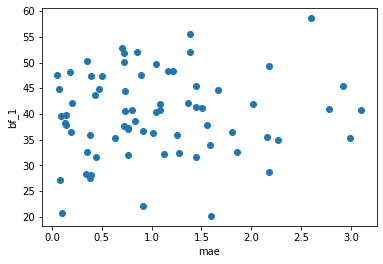

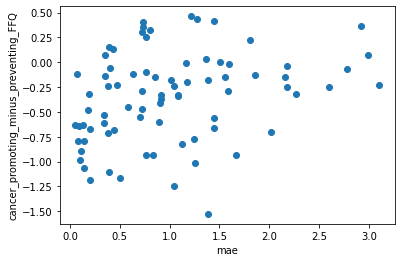

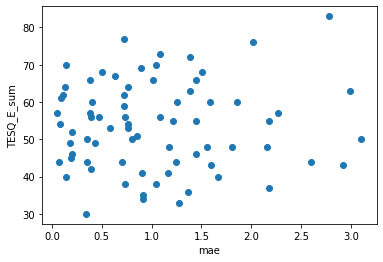

executive function_association-test_z_FDR_0.01
77.50632911392405


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


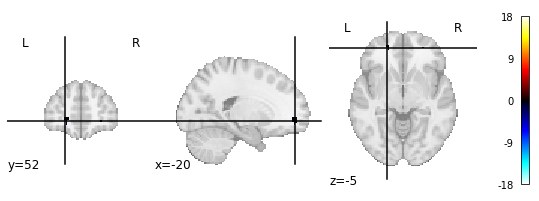

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


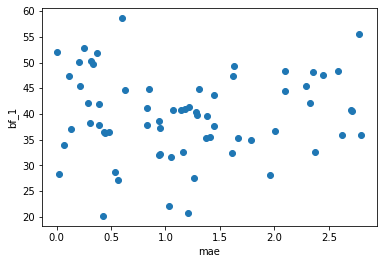

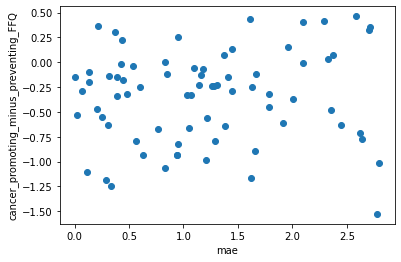

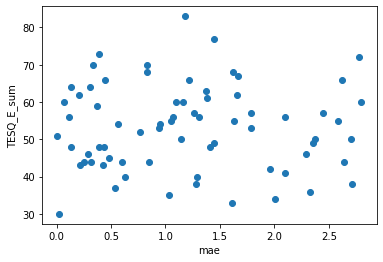

response inhibition_association-test_z_FDR_0.01
1291.1645569620252


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


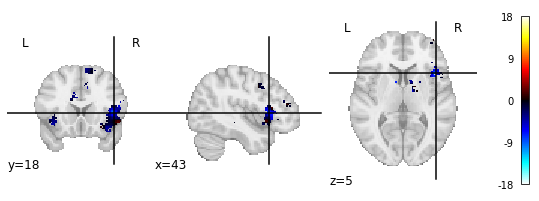

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


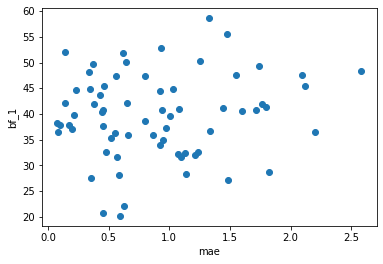

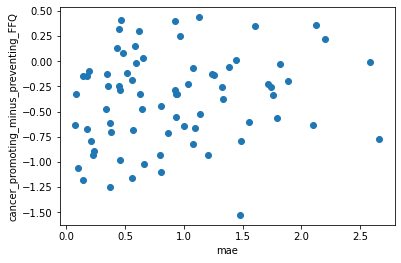

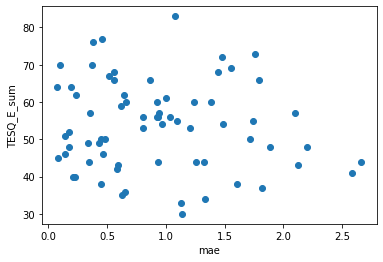

inhibition_association-test_z_FDR_0.01
436.0886075949367


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


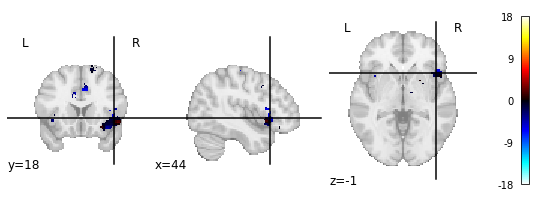

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


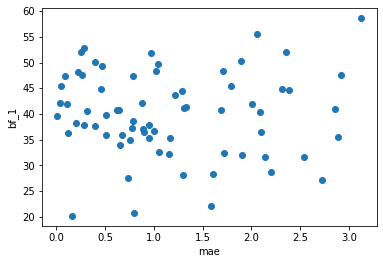

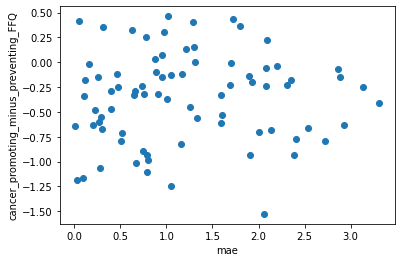

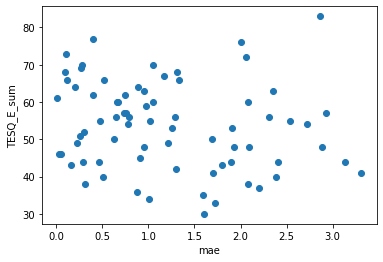

harvardoxford-cortical_prob_Frontal Orbital Cortex
2847.012658227848


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


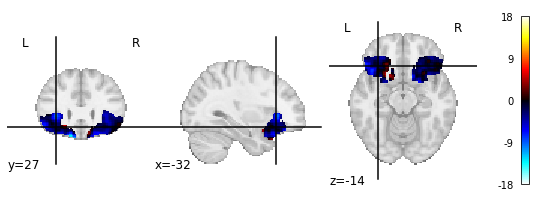

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


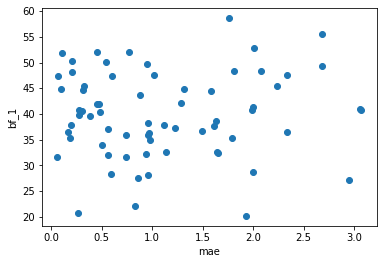

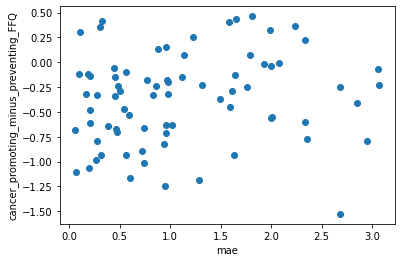

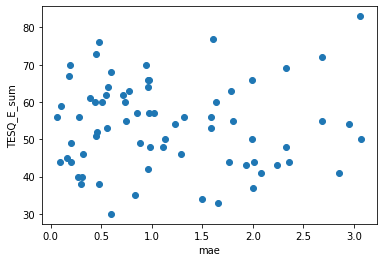

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
1471.4303797468353


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


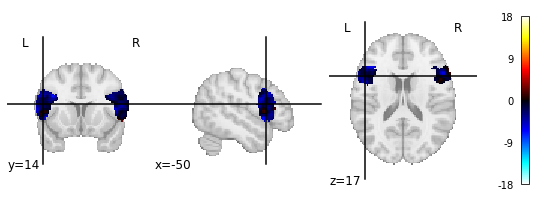

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


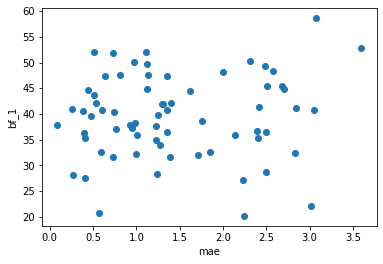

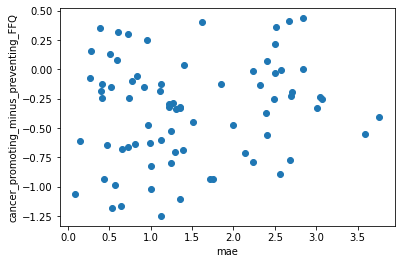

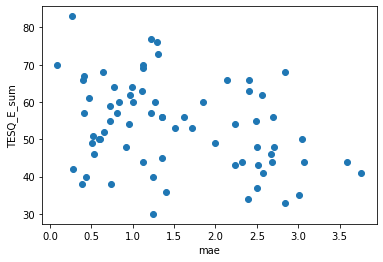

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
1538.620253164557


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


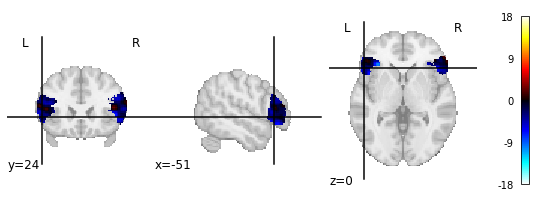

...............................................................................
Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)


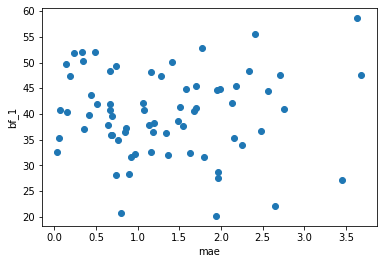

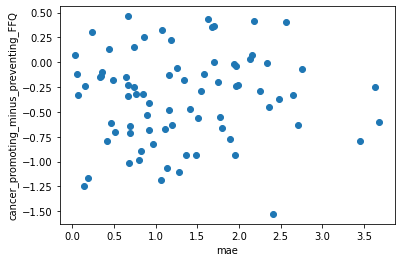

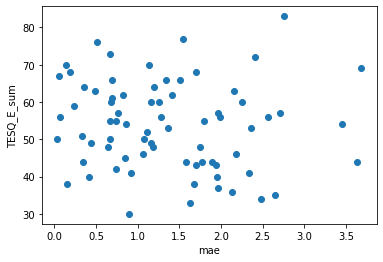

In [45]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):

        target='SST_SSRT'

        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)

        Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
        print("")

#             prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
#             forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

#             forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
#             forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



        #print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_regression_results(forced_choice_results,['mae'])

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
108520.02531645569


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


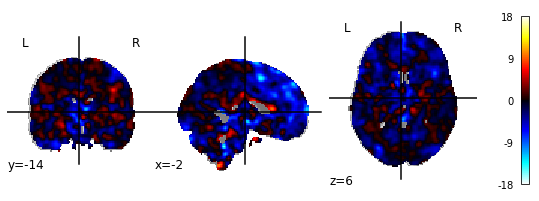

..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.3466e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.55211e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27406e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.11435e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.01995e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22174e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1365e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29197e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.37195e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14587e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.3401e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.4792e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.13074e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.51638e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.10771e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42884e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16605e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24135e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27849e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.17444e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.51536e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.03639e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.32662e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.47439e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.263e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14526e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24325e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.36e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.33944e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41993e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16458e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16236e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27412e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.81581e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41303e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29131e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22977e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.99843e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.44902e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.88395e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.28041e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1843e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.78835e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16703e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.57511e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42558e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.4367e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.63866e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.40746e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.23091e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29997e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22218e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.05825e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.30593e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.46081e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24517e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.43528e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.42074e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.99017e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.1692e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.41775e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22715e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.34319e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.15753e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.10879e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24447e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27121e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22157e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.27406e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.06374e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.056e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.48659e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.05474e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.16402e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.22216e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


..

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.14187e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.29135e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


.

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.13431e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.32289e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)



Index(['subject', 'cancer_promoting_minus_preventing_FCI',
       'cancer_promoting_minus_preventing_FFQ',
       'cancer_promoting_minus_preventing_craved_FCI',
       'cancer_promoting_minus_preventing_craved_FFQ',
       'cancer_promoting_minus_preventing_liked_FCI',
       'cancer_promoting_minus_preventing_liked_FFQ', 'cancer_promoting_FCI',
       'cancer_promoting_FFQ', 'cancer_preventing_FCI',
       ...
       'IPAQ_vigorousMETminutes', 'IPAQ_total_METminutes', 'IPAQ_MET_kCal',
       'birthsex_factor', 'wave', 'subj_wave', 'chunks', 'target_y', 'pred_y',
       'mae'],
      dtype='object', length=132)
BFI_extraversion


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.00275e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


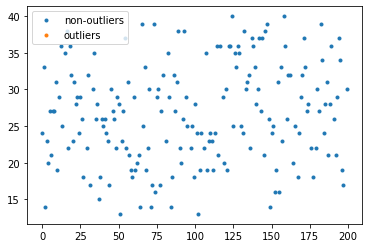

187 , 187
RMQ_locomotion


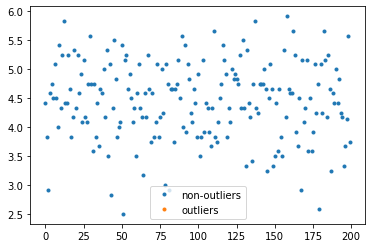

200 , 200
ses_aggregate


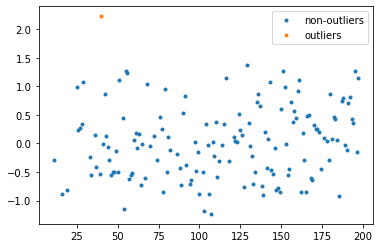

150 , 149
ses_aggregate


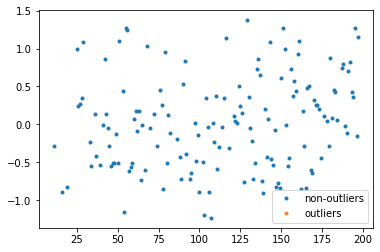

149 , 149
PLAN_cognitive_strategies


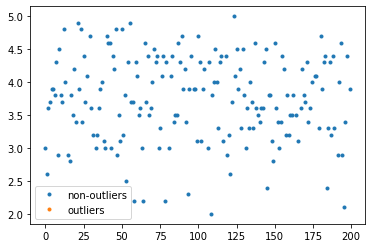

187 , 187
SST_SSRT


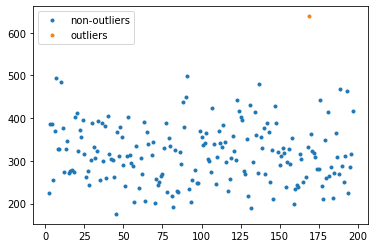

192 , 191
SST_SSRT


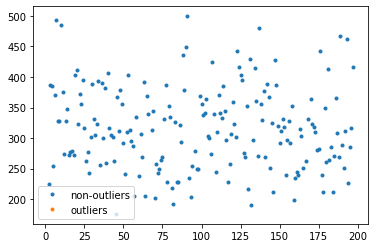

191 , 191
BIS_11


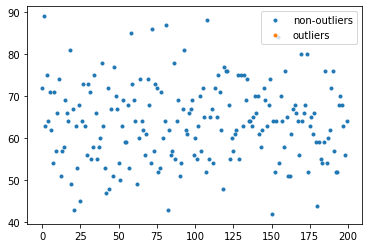

200 , 200
BSCS


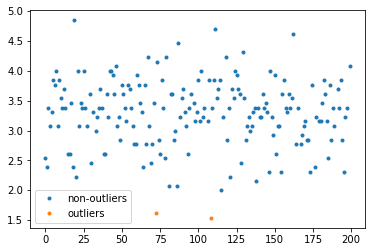

187 , 185
BSCS


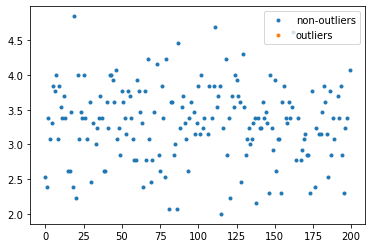

185 , 185
TESQ_E_suppression


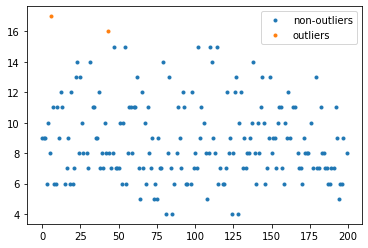

186 , 184
TESQ_E_suppression


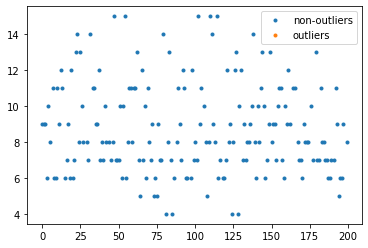

184 , 184
TESQ_E_avoidance_of_temptations


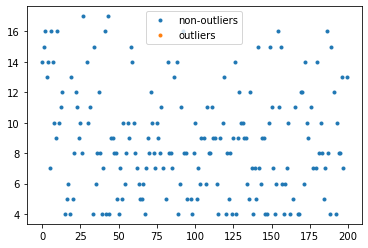

186 , 186
TESQ_E_goal_deliberation


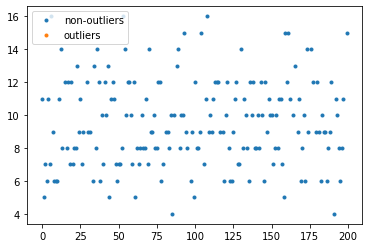

186 , 186
TESQ_E_controlling_temptations


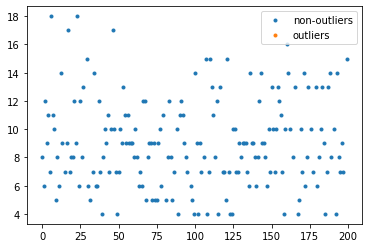

186 , 186
TESQ_E_distraction


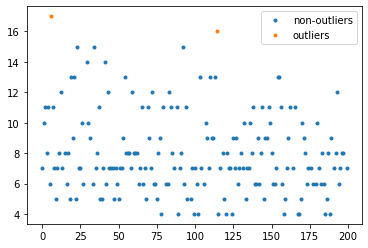

186 , 184
TESQ_E_distraction


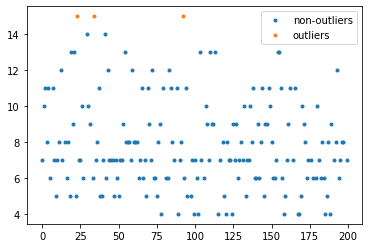

184 , 181
TESQ_E_distraction


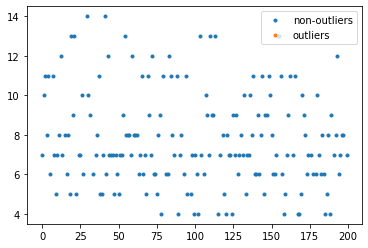

181 , 181
TESQ_E_goal_and_rule_setting


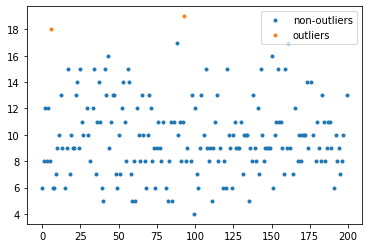

186 , 184
TESQ_E_goal_and_rule_setting


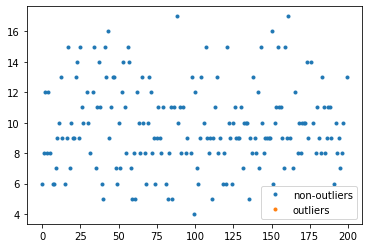

184 , 184
TESQ_E_sum


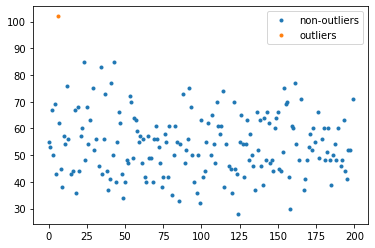

186 , 185
TESQ_E_sum


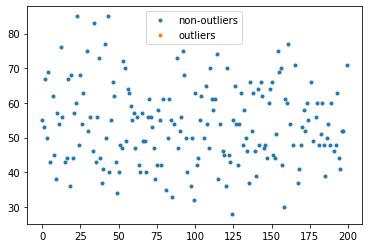

185 , 185
EDM


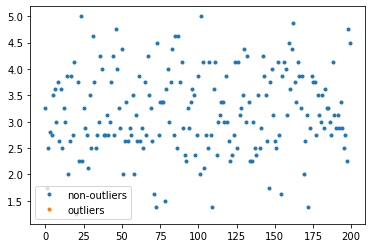

200 , 200
RS


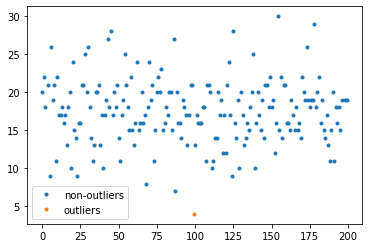

198 , 197
RS


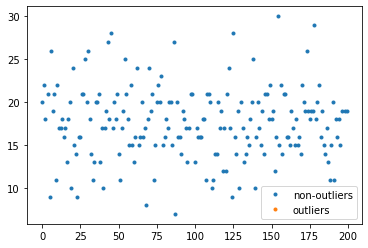

197 , 197
TRSQ


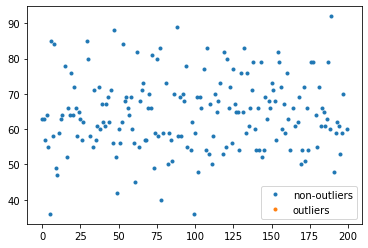

186 , 186
ROC_Crave_Regulate_Minus_Look


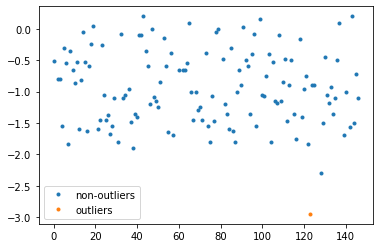

131 , 130
ROC_Crave_Regulate_Minus_Look


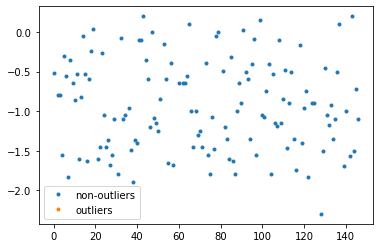

130 , 130
SRHI_unhealthy


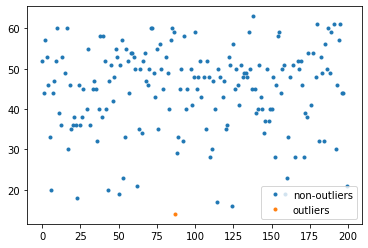

187 , 186
SRHI_unhealthy


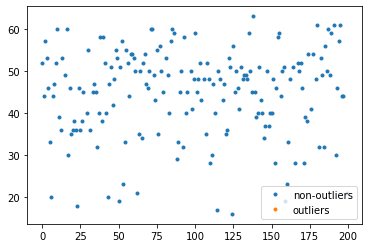

186 , 186
cancer_promoting_minus_preventing_FFQ


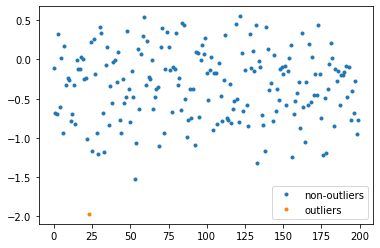

200 , 199
cancer_promoting_minus_preventing_FFQ


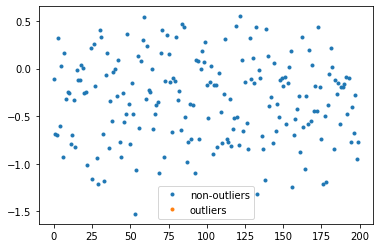

199 , 199
bf_1


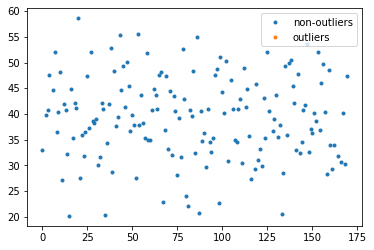

163 , 163
mae


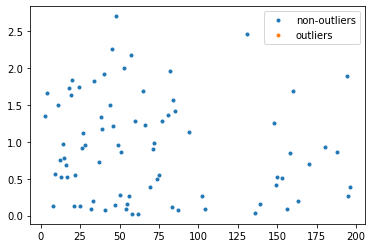

79 , 79


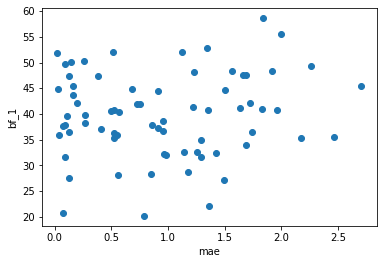

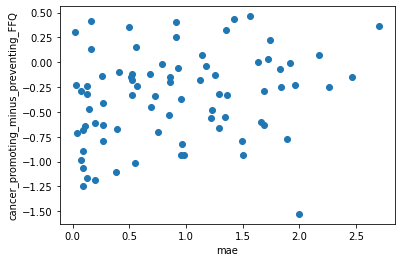

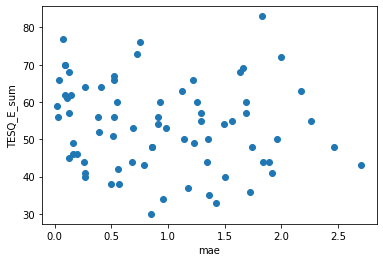

In [57]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast.pkl"
)

target='SST_SSRT'

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

print(mask_name)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(masked_preview,vmax=18)
plotting.show()
forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
print("")


forced_choice_results_dict[mask_name]=forced_choice_results
print_regression_results(forced_choice_results,['mae'])